# Importing needed packages and Main Parameters

In [178]:
# Standard:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import os
import sys

# From utils.py
levels = 2
sys.path.append(os.path.abspath(os.path.join(".", "../"*levels)))
import utils

# Prophet Package:
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.make_holidays import make_holidays_df
from prophet.utilities import regressor_coefficients
from prophet.plot import plot_cross_validation_metric
from prophet.serialize import model_from_dict, model_to_dict, model_from_json, model_to_json, SIMPLE_ATTRIBUTES

# Hyperopt:
from hyperopt import fmin, tpe, hp, anneal, Trials, SparkTrials, STATUS_OK, space_eval

# Definitions:
granularity = "Daily"
category = "Non-domestic"

# Input Paths:
demand_path = "../../data/gross_demand_daily.parquet"
h_weather_path = "../../data/gb_historic_hourly_weather.parquet"
h_average_weather_path = "../../data/gb_average_hourly_weather.parquet"
daylight_path = "../../data/gb_astronomical_data.parquet"

# Output Paths:
outputs_path = "../../outputs/daily"

# Default parameters for scoring models:
daily_cross_val_horizon = '366 days'
daily_initial = '2190 days'
daily_period = '180 days'

# Do not show Warnings
import warnings
warnings.filterwarnings("ignore")

# Suppress log messages from cmdstanpy and prophet
import logging
logging.getLogger('cmdstanpy').setLevel(logging.ERROR)
logging.getLogger('prophet').setLevel(logging.ERROR)

pd.options.display.max_columns = 100

# Data Manipulation

## Demand Table as pd.DataFrame

In [103]:
# Demand DataFrame
df = pd.read_parquet(demand_path).rename(columns={'settlement_date' : 'date'})
df = df.groupby(by=['date', 'sector'])[['total_corrected_consumption_gwh']].sum().reset_index()
df = df[ (df['sector'] == category)].rename(columns={
'total_corrected_consumption_gwh': 'y',
'date': 'ds'}).reset_index(drop=True).sort_values('ds')
initial_date = df['ds'].min()
final_date = df['ds'].max()
initial_year = initial_date.year
final_year = final_date.year

## Regressors Tables as pd.DataFrame
- Daylight time by day for weekly variation throughout the year

In [104]:
# Regressors DataFrame
daylight = pd.read_parquet(daylight_path)
daylight['daylight_duration'] = (daylight['daylight_duration'] - daylight['daylight_duration'].min())
daylight = daylight.groupby(by='date')[['daylight_duration']].mean() * -1

weekend = pd.DataFrame({'ds' : pd.date_range(start=initial_date, end=datetime.date(2051,3,31), freq='D')})
weekend['sat_reg'] = weekend['ds'].apply(lambda x: daylight.loc[x,'daylight_duration'] if x.weekday() == 5 else 0)
weekend['sun_reg'] = weekend['ds'].apply(lambda x: daylight.loc[x,'daylight_duration'] if x.weekday() == 6 else 0)

temp = pd.read_parquet(h_weather_path)
temp = temp[temp['date'] < temp['date'].max()]
temp.columns = temp.columns.str.replace('gb_','')
temp = temp.rename(columns={'date':'ds'})
temp = temp.groupby('ds').agg(
  {'temperature' : 'mean',
  'hdd' : 'sum',
  'cdd' : 'sum'}).reset_index()

future_temp = pd.read_parquet(h_average_weather_path)
future_temp.columns = future_temp.columns.str.replace('gb_','')
future_temp = future_temp.rename(columns={'date':'ds'})
future_temp = future_temp.groupby('ds').agg(
  {'temperature' : 'mean',
  'hdd' : 'sum',
  'cdd' : 'sum'}).reset_index()
future_temp = future_temp[future_temp['ds'] > temp['ds'].max()]
future_temp = pd.concat([temp, future_temp]).reset_index(drop=True)

average_temp_all = pd.read_parquet(h_average_weather_path)
average_temp_all.columns = average_temp_all.columns.str.replace('gb_','')
average_temp_all = average_temp_all.rename(columns={'date':'ds'})
average_temp_all = average_temp_all.groupby('ds').agg(
  {'temperature' : 'mean',
  'hdd' : 'sum',
  'cdd' : 'sum'}).reset_index()

temp.head()

,ds,temperature,hdd,cdd
0,2015-01-01,9.994652,803.921260,0.0
1,2015-01-02,6.967103,1949.742425,0.0
2,2015-01-03,4.495221,2882.854784,0.0
3,2015-01-04,1.930792,3866.575854,0.0
4,2015-01-05,6.817229,1990.184090,0.0


## Extra Seasonality Table as pd.DataFrame
- COVID handling

In [105]:
# Extra Seasonality DataFrame
seasonality = pd.DataFrame({'ds' : pd.date_range(start=initial_date, end=datetime.date(2051,3,31), freq='D')})
seasonality['weekly_covid_addition'] = ((pd.to_datetime(seasonality['ds']) >= pd.to_datetime('2020-03-21')) & (pd.to_datetime(seasonality['ds']) < pd.to_datetime('2021-03-21')))
seasonality['yearly_covid_addition'] = ((pd.to_datetime(seasonality['ds']) >= pd.to_datetime('2020-03-21')) & (pd.to_datetime(seasonality['ds']) < pd.to_datetime('2022-02-20')))
seasonality['weekly_post_covid_addition'] = ((pd.to_datetime(seasonality['ds']) >= pd.to_datetime('2021-03-21')) & (pd.to_datetime(seasonality['ds']) < pd.to_datetime('2022-02-20')))
seasonality['weekly_new_normal'] = ((pd.to_datetime(seasonality['ds']) >= pd.to_datetime('2022-02-20')))
seasonality['yearly_post_covid_addition'] = ((pd.to_datetime(seasonality['ds']) >= pd.to_datetime('2022-02-20')))
seasonality.head()

,ds,weekly_covid_addition,yearly_covid_addition,weekly_post_covid_addition,weekly_new_normal,yearly_post_covid_addition
0,2015-01-01,False,False,False,False,False
1,2015-01-02,False,False,False,False,False
2,2015-01-03,False,False,False,False,False
3,2015-01-04,False,False,False,False,False
4,2015-01-05,False,False,False,False,False


## Merging Demand df with Regressors, Seasonality, etc.

In [106]:
df = df.merge(temp, how='inner', on='ds').merge(weekend, how='inner', on='ds').merge(seasonality, how='inner', on='ds')

## Creating future DataFrame for forecasting with the utilised Regressors, Seasonality, etc.

In [107]:
# Future df
future_df = pd.DataFrame({'ds': pd.date_range(start=initial_date, end=final_date + datetime.timedelta(days=30), freq='D')})
future_df['sector'] = category
future_df = future_df.merge(future_temp, how='left', on='ds').merge(weekend, how='inner', on='ds').merge(seasonality, how='left', on='ds')
future_df.head()

,ds,sector,temperature,hdd,cdd,sat_reg,sun_reg,weekly_covid_addition,yearly_covid_addition,weekly_post_covid_addition,weekly_new_normal,yearly_post_covid_addition
0,2015-01-01,Non-domestic,9.994652,803.921260,0.0,0.00000,0.000000,False,False,False,False,False
1,2015-01-02,Non-domestic,6.967103,1949.742425,0.0,0.00000,0.000000,False,False,False,False,False
2,2015-01-03,Non-domestic,4.495221,2882.854784,0.0,-548.45706,0.000000,False,False,False,False,False
3,2015-01-04,Non-domestic,1.930792,3866.575854,0.0,0.00000,-637.048949,False,False,False,False,False
4,2015-01-05,Non-domestic,6.817229,1990.184090,0.0,0.00000,0.000000,False,False,False,False,False


## Creating the Holidays Dataframe using holidays version 0.26
- Differencing by DOW manually.
- Including Beast of the East.
- Including Lockdown regressors.

In [108]:
# Creating Holidays df

holidays_dic = {
1 : 'dow12',
2 : 'dow12',
3 : 'dow34',
4 : 'dow34',
5 : 'dow5',
6 : 'dow6',
7 : 'dow7'}

year_list = list(range(2015,2024+1))
holidays = make_holidays_df(year_list=year_list, country='UK')

# Dropping Norther Ireland's holidays & Christmas Holidays as these will be added depending on the day-of-week
northern_ireland = ["St. Patrick's Day [Northern Ireland]", "Battle of the Boyne [Northern Ireland]", "St. Patrick's Day [Northern Ireland] (Observed)"]
holidays = holidays[~holidays['holiday'].isin(northern_ireland)]
drop_xmas_ny = ['Boxing Day', 'Boxing Day (Observed)', 'Christmas Day', 'New Year Holiday [Scotland]', "New Year's Day"]
holidays = holidays[~holidays['holiday'].isin(drop_xmas_ny)]
holidays['lower_window'] = -1
holidays['upper_window'] = 1

# Lockdowns + Beast of the East as one-off holiday
lockdowns = pd.DataFrame([
  {'holiday': 'beast_of_the_east', 'ds': '2018-02-24', 'lower_window': 0, 'ds_upper': '2018-04-19'},
  {'holiday': 'lockdown_1', 'ds': '2020-03-21', 'lower_window': 0, 'ds_upper': '2020-06-30'},
  {'holiday': 'lockdown_2', 'ds': '2020-10-25', 'lower_window': 0, 'ds_upper': '2020-12-15'},
  {'holiday': 'lockdown_3', 'ds': '2021-02-15', 'lower_window': 0, 'ds_upper': '2021-03-12'}])
for t_col in ['ds', 'ds_upper']:
    lockdowns[t_col] = pd.to_datetime(lockdowns[t_col])
lockdowns['upper_window'] = (lockdowns['ds_upper'] - lockdowns['ds']).dt.days
lockdowns = lockdowns.drop(columns='ds_upper')

## Christmas Holidays depending on the day-of-week
add_xmas_ny = ["12_22", "12_23", "12_24", "12_25", "12_26", "12_27", "12_28", "12_29", "12_30", "12_31", "1_1", "1_2"]
extra_holidays = pd.DataFrame({'ds':pd.date_range(start='2015-01-01', end='2050-12-31')})
extra_holidays['month_day'] = extra_holidays['ds'].dt.month.astype(str) + '_' + extra_holidays['ds'].dt.day.astype(str)
extra_holidays = extra_holidays[extra_holidays['month_day'].isin(add_xmas_ny)]
extra_holidays['group'] = extra_holidays['ds'].dt.dayofweek + 1
extra_holidays['group'] = extra_holidays['group'].map(holidays_dic)
extra_holidays.loc[:,'holiday'] = 'xmas_ny_' + extra_holidays.loc[:,'month_day'] + '_' + extra_holidays.loc[:,'group'] 
extra_holidays = extra_holidays.drop(columns=['month_day', 'group'])
extra_holidays['lower_window'] = 0
extra_holidays['upper_window'] = 0

## Merging the DataFrames
holidays = pd.concat([holidays,lockdowns]).reset_index(drop=True)
holidays = pd.concat([holidays,extra_holidays]).reset_index(drop=True)
holidays = holidays.sort_values('ds')
holidays['holiday'] = holidays['holiday'].str.lower()
holidays['holiday'] = holidays['holiday'].str.replace(" ","_", regex=False)
holidays['holiday'] = holidays['holiday'].str.replace("'","", regex=False)
holidays['holiday'] = holidays['holiday'].str.replace(".","", regex=False)
holidays['holiday'] = holidays['holiday'].str.replace("/","_", regex=False)
holidays['holiday'] = holidays['holiday'].str.replace("(","", regex=False)
holidays['holiday'] = holidays['holiday'].str.replace(")","", regex=False)
holidays['holiday'] = holidays['holiday'].str.replace("[","", regex=False)
holidays['holiday'] = holidays['holiday'].str.replace("]","", regex=False)


# Modelling

## Dummy Model Initialisation for easier Hyper-parameters' optimisation spaces

In [109]:
# Forecasting Timeseries - Initializing a 

model = Prophet( # Default values
  growth = 'linear',
  seasonality_mode = 'multiplicative',
  holidays_mode = 'multiplicative',
  changepoints=None,
  n_changepoints=25,
  changepoint_range=0.8,
  holidays=holidays,
  seasonality_prior_scale=10.0,
  holidays_prior_scale=10.0,
  changepoint_prior_scale=0.05,
  mcmc_samples=0,
  interval_width=0.80,
  uncertainty_samples=1000,
  yearly_seasonality = True,
  weekly_seasonality = True,
  daily_seasonality = False
)

for reg in df.drop(columns=['ds', 'sector', 'y', 'weekly_covid_addition', 'yearly_covid_addition', 'weekly_post_covid_addition', 'weekly_new_normal', 'yearly_post_covid_addition']).columns:
  model.add_regressor(reg,
                      mode='multiplicative')

for name, period, fourier_order in zip(seasonality.drop(columns='ds').columns.tolist(), [7,730.5,7,7,365.25], [3,15,3,3,10]): # Period, Fourier order
  model.add_seasonality(name=name,
                        period=period,
                        fourier_order=fourier_order,
                        condition_name=name)

## HyperOpt Search Distributions, Search Spaces, Search Algorithm, etc.

In [110]:
# HyperOpt:

daily_base_tuning = ['changepoint_prior_scale', 'seasonality_prior_scale', 'holidays_prior_scale', 'changepoint_range']

daily_base_hyperopt = {
  'changepoint_prior_scale' : (0.01, 0.05),
  'seasonality_prior_scale': (5, 30),
  'holidays_prior_scale': (5, 30),
  'changepoint_range': (0.99, 1)}

daily_regressors_hyperopt = {
  'temperature' : (5, 30),
  'hdd' : (5, 30),
  'cdd' : (5, 30),
  'sat_reg' : (5, 30),
  'sun_reg' : (5, 30)}

space = {}
space_dict = {}

# Creating the HyperOpt Space for the tuning [We could use log instead of uniform?]
for item in daily_base_tuning:
  space[item] = hp.uniform(item, daily_base_hyperopt[item][0], daily_base_hyperopt[item][1])
  space_dict[item] = ('hp.uniform', daily_base_hyperopt[item][0], daily_base_hyperopt[item][1])

for item in [i for i in model.extra_regressors]:
  space[item] = hp.uniform(item, daily_regressors_hyperopt[item][0], daily_regressors_hyperopt[item][1])
  space_dict[item] = ('hp.uniform', daily_regressors_hyperopt[item][0], daily_regressors_hyperopt[item][1])

# HyperOpt algorithm and +
algo = tpe.suggest
max_evals = 1
trials = Trials()
rstate = np.random.default_rng(42)

## Function for HyperOpt to run.
- The function is literally a model fitting with the HyperOpt variables and scoring depending on the cross_validation's metric (MAPE here)

In [111]:
def hyperopt_tuning(hyperopt):

  global model

  # Creating the forecasting model with the variables we are using: multiplicative, holidays, regressors, seasonalities.
  model = Prophet( # Default values
  growth = 'linear',
  seasonality_mode = 'multiplicative',
  holidays_mode = 'multiplicative',
  changepoints=None,
  n_changepoints=25,
  changepoint_range=0.8,
  holidays=holidays,
  seasonality_prior_scale=10.0,
  holidays_prior_scale=10.0,
  changepoint_prior_scale=0.05,
  mcmc_samples=0,
  interval_width=0.80,
  uncertainty_samples=1000,
  yearly_seasonality = True,
  weekly_seasonality = True,
  daily_seasonality = False
)

  for reg in df.drop(columns=['ds', 'sector', 'y', 'weekly_covid_addition', 'yearly_covid_addition', 'weekly_post_covid_addition', 'weekly_new_normal', 'yearly_post_covid_addition']).columns:
    model.add_regressor(reg,
                        mode='multiplicative')

  for name, period, fourier_order in zip(seasonality.drop(columns='ds').columns.tolist(), [7,730.5,7,7,365.25], [3,15,3,3,10]): # Period, Fourier order
    model.add_seasonality(name=name,
                          period=period,
                          fourier_order=fourier_order,
                          condition_name=name)

  # Using Hyperopt to tune the base hyperparams: changepoint_prior_scale, seasonality_prior_scale, holidays_prior_scale, changepoint_range.
  for hyperparam in daily_base_tuning:
    setattr(model, hyperparam, hyperopt[hyperparam])

  # Using Hyperopt to tune the extra hyperparams: regressors unique to the model.
  for regressor_hyperparam in [i for i in model.extra_regressors]:
    model.extra_regressors[regressor_hyperparam]['prior_scale'] = hyperopt[regressor_hyperparam]

  # For the extra seasonalities:
  for season in ['weekly_covid_addition', 'yearly_covid_addition', 'weekly_post_covid_addition', 'weekly_new_normal', 'yearly_post_covid_addition']:
    model.seasonalities[season]['prior_scale'] = hyperopt['seasonality_prior_scale']

  # Fitting the model with the hyperopt variables to optimize them using the aglorithm "Tree of Parzen Estimators" by default. This can be changed.
  model.fit(df)

  # Scoring parameters for each iteration in the optimization.
  df_cv = cross_validation(model, initial=daily_initial, period=daily_period, horizon=daily_cross_val_horizon)
  df_p = performance_metrics(df_cv, rolling_window=1)
  df_p['cutoff_points'] = len(df_cv['cutoff'].unique())
  score = df_p['mape'].values[0]

  return {
  'loss' : score,
  'status' : STATUS_OK,
  'cutoff_points' : df_p['cutoff_points'][0], 
  'horizon_days' : df_p['horizon'][0].days,
  'metrics' : dict(zip(df_p.columns[1:-2], df_p.values[0][1:-2])),
  'prophet_dict' : model_to_dict(model),
  'category' : category,
  'granularity' : granularity,
  'hopt_algorithm' : algo.__module__,
  'max_iters' : max_evals,
  'random_state' : rstate,
  'training_datetime' : datetime.datetime.today()
  } 

In [112]:
## In this case the Loss Score is very high because of the artificial seasonalities placed because of COVID.
# The model, at a cut_off point "2021" can't fit the extra seasonalities that are applied to the model.
# Still, the model is getting the posterior distributions by fitting the whole dataset
hyperopt_optimization = fmin(fn=hyperopt_tuning,
                              space = space,
                              algo= algo,
                              max_evals=max_evals,
                              trials= trials,
                              rstate= rstate)

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:12<00:00, 12.98s/trial, best loss: 0.17794463019030757]


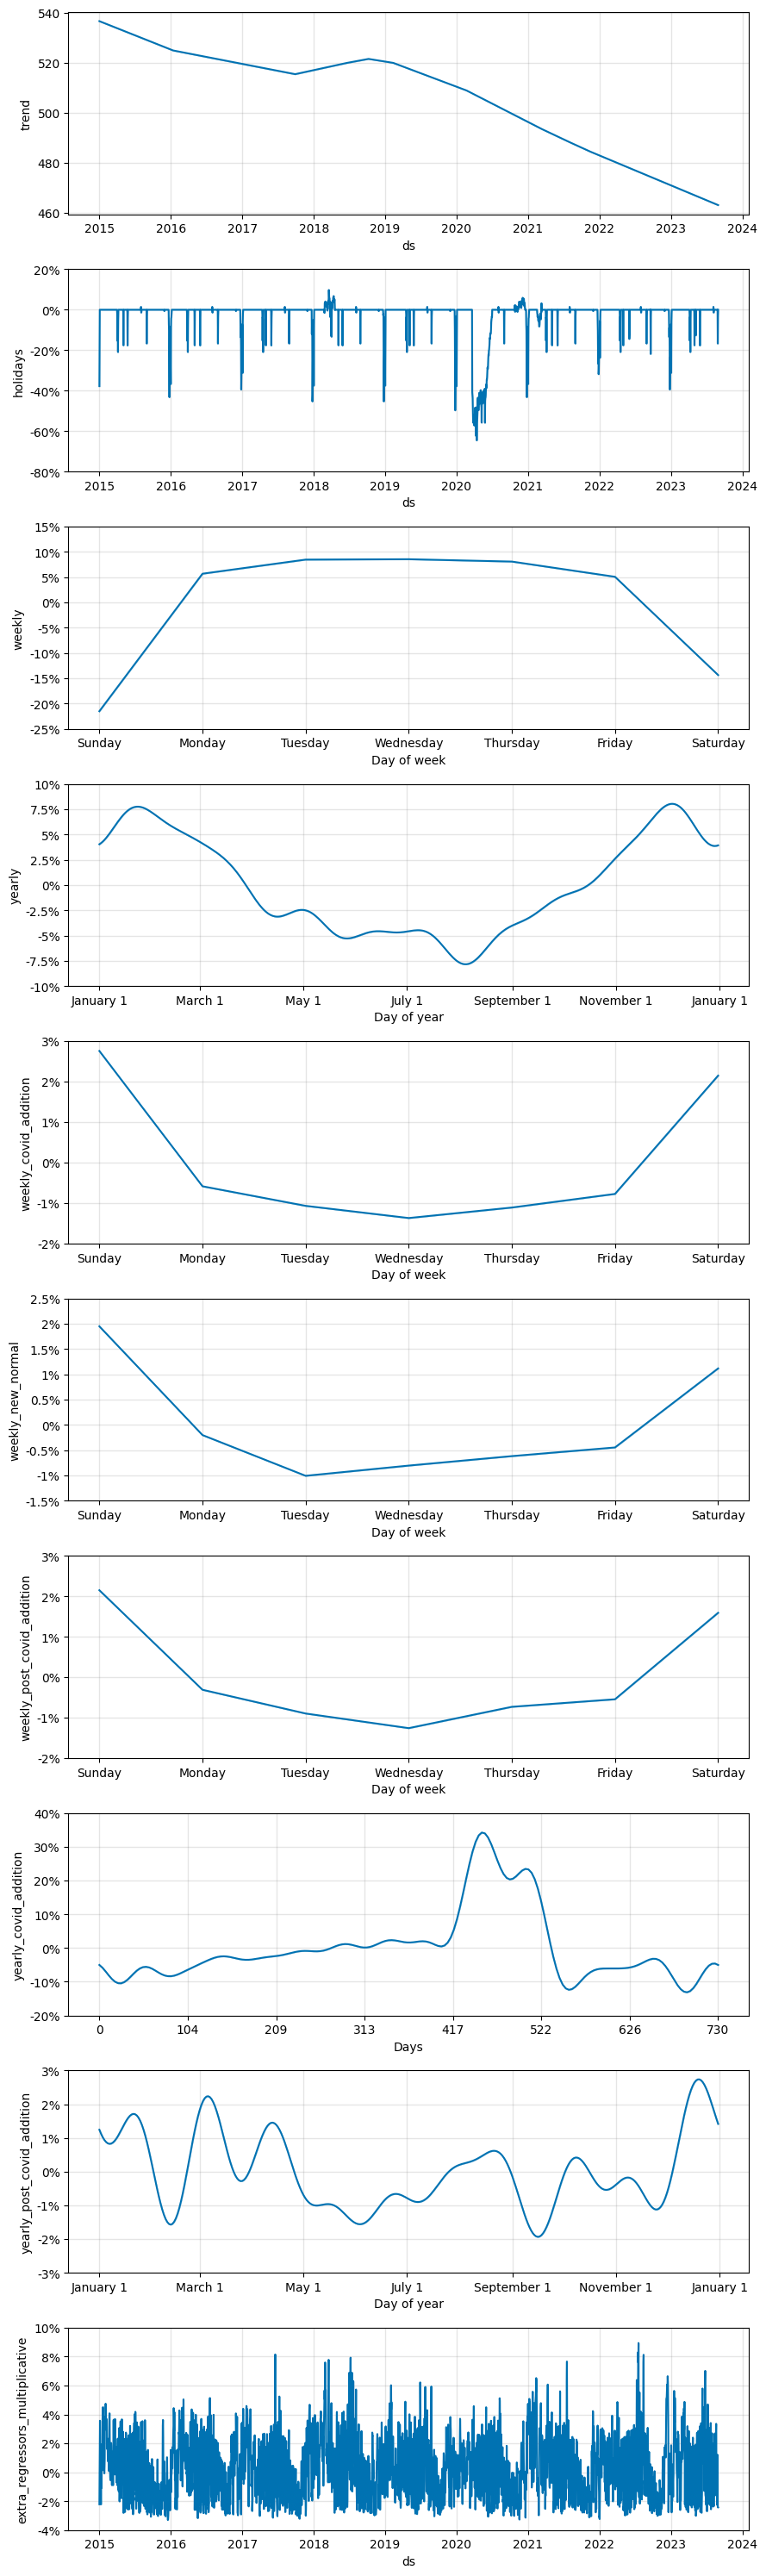

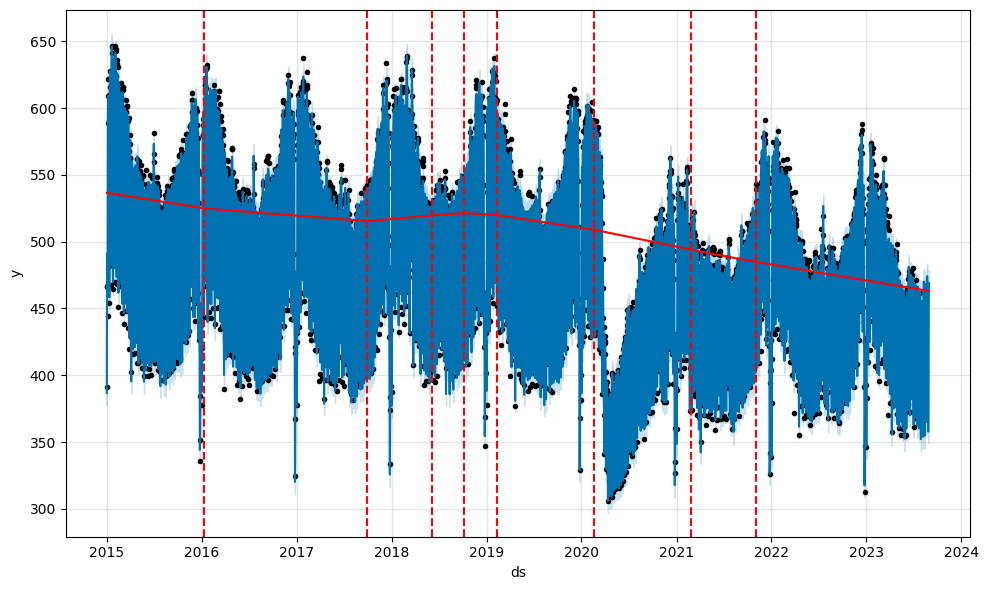

In [113]:
# Plotting the model's components and forecast including Backcast
best_model = model_from_dict(trials.best_trial['result']['prophet_dict'])
forecast = best_model.predict(future_df)
fig = best_model.plot_components(forecast)
plt.show()
fig = best_model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), best_model, forecast)
plt.show()

# Prophet() Formulas, components, etc. understanding

## Looking into the components within the Prophet Python Object

In [114]:
### Parameters of the best model (Look for definitions in PPT)
# lp >> Log posterior density of the model parameters.
# k >> Growth rate parameter (slope).
# m >> initial intercept.
# delta [preprocess S size] >> slope change at each changepoint.
# sigma_obs >> standard deviation of the observations.
# beta [preprocess K size] >> coefficients for seasonality, holidats, regressors.
# trend [preprocess T size] >> estimated trend at each datetime.

best_model = model_from_dict(trials.best_trial['result']['prophet_dict'])
forecast = best_model.predict(future_df)
print([x for x in best_model.params])
[best_model.params[x].size for x in best_model.params]

['lp__', 'k', 'm', 'delta', 'sigma_obs', 'beta', 'trend']


[1, 1, 1, 25, 1, 433, 3134]

In [115]:
# Default forecast DataFrame
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,beast_of_the_east,beast_of_the_east_lower,beast_of_the_east_upper,cdd,...,yearly_covid_addition,yearly_covid_addition_lower,yearly_covid_addition_upper,yearly_post_covid_addition,yearly_post_covid_addition_lower,yearly_post_covid_addition_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2015-01-01,536.586147,377.938934,395.801155,536.586147,536.586147,0.0,0.0,0.0,-0.001251,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,386.750967
1,2015-01-02,536.554989,457.380105,475.984947,536.554989,536.554989,0.0,0.0,0.0,-0.001251,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,466.596996
2,2015-01-03,536.523831,482.480087,500.880367,536.523831,536.523831,0.0,0.0,0.0,-0.001251,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,491.299276
3,2015-01-04,536.492672,455.232494,472.384800,536.492672,536.492672,0.0,0.0,0.0,-0.001251,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,463.781393
4,2015-01-05,536.461514,580.946760,599.873628,536.461514,536.461514,0.0,0.0,0.0,-0.001251,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,591.205232


In [116]:
# 1 for each coefficient
# There are 3 columns grouping holidays, regressors and all terms: holidays, extra_regressors_multiplicative, multiplicative_terms.
# Dropping them, the sum of 1s if beta [preprocess K size]

components = model.train_component_cols
print(components.drop(columns=['holidays', 'extra_regressors_multiplicative', 'multiplicative_terms']).sum().sum())
components.drop(columns=['holidays', 'extra_regressors_multiplicative', 'multiplicative_terms']).T.sum(axis=1)

433


component
beast_of_the_east                               55
cdd                                              1
christmas_day_observed                           3
coronation_of_charles_iii                        3
easter_monday_england_wales_northern_ireland     3
                                                ..
xmas_ny_1_2_dow7                                 1
yearly                                          20
yearly_covid_addition                           30
yearly_post_covid_addition                      20
additive_terms                                   0
Length: 90, dtype: int64

In [117]:
# Coefficients and values of the extra_regressors
regressor_coefficients(best_model)

,regressor,regressor_mode,center,coef_lower,coef,coef_upper
0,temperature,multiplicative,10.551490,0.004256,0.004256,0.004256
1,hdd,multiplicative,1191.209680,0.000030,0.000030,0.000030
2,cdd,multiplicative,46.788950,0.000027,0.000027,0.000027
3,sat_reg,multiplicative,-2461.160909,-0.000001,-0.000001,-0.000001
4,sun_reg,multiplicative,-2462.458013,-0.000002,-0.000002,-0.000002


In [118]:
# Example of the normal distribution of the extra_regressor "temperature"
print(best_model.extra_regressors['temperature'])

{'prior_scale': 25.341385191007195, 'standardize': 'auto', 'mu': 10.551489714313586, 'std': 4.924583311691614, 'mode': 'multiplicative'}


In [119]:
# All the extra_regressors' parameters
best_model.extra_regressors

OrderedDict([('temperature',
              {'prior_scale': 25.341385191007195,
               'standardize': 'auto',
               'mu': 10.551489714313586,
               'std': 4.924583311691614,
               'mode': 'multiplicative'}),
             ('hdd',
              {'prior_scale': 7.844906679590178,
               'standardize': 'auto',
               'mu': 1191.2096798120165,
               'std': 1215.0307111777581,
               'mode': 'multiplicative'}),
             ('cdd',
              {'prior_scale': 17.104622645962277,
               'standardize': 'auto',
               'mu': 46.78895007088999,
               'std': 167.2485403739787,
               'mode': 'multiplicative'}),
             ('sat_reg',
              {'prior_scale': 21.293559993722347,
               'standardize': 'auto',
               'mu': -2461.1609085079767,
               'std': 7426.119005411078,
               'mode': 'multiplicative'}),
             ('sun_reg',
              {'prior_scale

In [120]:
# Looking at the Inputs we give the model after they've been preprocessed (scaling, etc)
[
  'K', # number of variables' coefficients [BETA size in model.params].
  'S', # number of slope changes (at each changepoint) [DELTA size in model.params].
  'T', # number of estimated values of the trend component of the time series at each time point. [TREND size in model.params].
  'X', # Dataframe of TxK (each time series point and the variables coefficients as columns).
  'cap', # for logistic growth.
  's_a', # additive terms.
  's_m', # multiplicative terms.
  'sigmas', # Coefficients' prior_scales (Hyperparameters)
  't', # time.
  't_change', # value of t at changepoints.
  'tau', # changepoint prior_scale >> flexibility.
  'trend_indicator',
  'y' # standardized y values.
  ]
preprocess = best_model.preprocess(df)
preprocess

ModelInputData(T=3134, S=25, K=433, tau=0.022959961428617358, trend_indicator=0, y=0       0.605498
1       0.721956
2       0.720935
3       0.687846
4       0.911639
          ...   
3129    0.714278
3130    0.686955
3131    0.586022
3132    0.561941
3133    0.691771
Name: y_scaled, Length: 3134, dtype: float64, t=0       0.000000
1       0.000319
2       0.000638
3       0.000958
4       0.001277
          ...   
3129    0.998723
3130    0.999042
3131    0.999362
3132    0.999681
3133    1.000000
Name: t, Length: 3134, dtype: float64, cap=array([0., 0., 0., ..., 0., 0., 0.]), t_change=array([0.03989786, 0.07979572, 0.11969358, 0.15959145, 0.19948931,
       0.23938717, 0.27928503, 0.31918289, 0.35908075, 0.39897861,
       0.43887648, 0.47877434, 0.51835302, 0.55825088, 0.59814874,
       0.6380466 , 0.67794446, 0.71784232, 0.75774019, 0.79763805,
       0.83753591, 0.87743377, 0.91733163, 0.95722949, 0.99712735]), s_a=col
0      0
1      0
2      0
3      0
4      0
      ..
428   

In [121]:
# How the model parameters will be initialized under the number of regressors we are utilising:
print(best_model.calculate_initial_params(num_total_regressors=preprocess.K))

ModelParams(k=0.08627336127373642, m=0.605497829985039, delta=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.]), beta=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [122]:
## Saving model:
with open('serialized_model.json', 'w') as fout:
    fout.write(model_to_json(best_model))  # Save model

In [123]:
## Reading model:
with open('serialized_model.json', 'r') as fin:
    m = model_from_json(fin.read())  # Load model

# Post-processing

In [172]:
# Checking what are the input parameters and priors of the best model:
utils.hyper_params_df(trials)

,cdd,changepoint_prior_scale,changepoint_range,hdd,holidays_prior_scale,sat_reg,seasonality_prior_scale,sun_reg,temperature,cross_val_mape,cutoff_points,horizon_days,hopt_algorithm,max_iters,random_state,model_sector,model_granularity,model_mape,model_mdape,training_datetime
0,17.104623,0.02296,0.997156,7.844907,24.19641,21.29356,27.098166,20.502975,25.341385,0.177945,4,366,hyperopt.tpe,1,Generator(PCG64),Non-domestic,Daily,0.177945,0.177945,2024-10-01 17:43:56.852285


In [163]:
# Getting well formatted forecasts, etc.
best_model.granularity = granularity
best_model.future = future_df
best_model.holiday_names = utils.holiday_names_func(holidays)
best_model.xmas_ny = utils.xmas_ny_func(best_model.holiday_names)
best_model.holidays_date = utils.holidays_by_date(holidays, best_model.holiday_names)
best_model.forecast = forecast
best_model.full_forecast = utils.full_forecast_df(best_model)
best_model.reduced_forecast = utils.reduced_forecast_df(best_model)

In [166]:
best_model.full_forecast

,ds,y,sector,nominal_temperature,nominal_hdd,nominal_cdd,nominal_sat_reg,nominal_sun_reg,flag_weekly_covid_addition,flag_yearly_covid_addition,flag_weekly_post_covid_addition,flag_weekly_new_normal,flag_yearly_post_covid_addition,trend,yhat,yhat_lower,yhat_upper,trend_lower,trend_upper,holidays,multiplicative_terms,additive_terms,weekly_covid_addition,yearly_covid_addition,weekly_post_covid_addition,weekly_new_normal,yearly_post_covid_addition,yearly,weekly,temperature,hdd,cdd,sat_reg,sun_reg,good_friday,easter_monday_england_wales_northern_ireland,may_day,spring_bank_holiday,summer_bank_holiday_scotland,late_summer_bank_holiday_england_wales_northern_ireland,st_andrews_day_scotland,new_year_holiday_scotland_observed,christmas_day_observed,new_years_day_observed,beast_of_the_east,lockdown_1,lockdown_2,lockdown_3,platinum_jubilee_of_elizabeth_ii,state_funeral_of_queen_elizabeth_ii,coronation_of_charles_iii,xmas_ny,residual,error_percentage,total_yearly,total_weekly,weekly_weekend,yhat_detrended,daily_weighting,training_datetime
0,2015-01-01,391.343216,Non-domestic,9.994652,803.921260,0.000000,0.000000,0.000000,False,False,False,False,False,536.586147,386.750967,377.938934,395.801155,536.586147,536.586147,-0.377728,-0.279238,0.0,0.0,0.0,0.0,0.000000,0.000000,0.039848,0.080803,-0.002370,-0.011525,-0.001251,-0.003094,-0.003921,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.377728,-4.592249,-0.011735,0.039848,0.073788,-0.007015,0.737628,0.022093,2024-10-01 18:07:50.363228
1,2015-01-02,466.612301,Non-domestic,6.967103,1949.742425,0.000000,0.000000,0.000000,False,False,False,False,False,536.554989,466.596996,457.380105,475.984947,536.554989,536.554989,-0.221037,-0.130384,0.0,0.0,0.0,0.0,0.000000,0.000000,0.040889,0.050713,-0.015255,0.022572,-0.001251,-0.003094,-0.003921,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.221037,-0.015306,-0.000033,0.040889,0.043698,-0.007015,0.887113,0.026570,2024-10-01 18:07:50.363228
2,2015-01-03,465.952047,Non-domestic,4.495221,2882.854784,0.000000,-548.457060,0.000000,False,False,False,False,False,536.523831,491.299276,482.480087,500.880367,536.523831,536.523831,0.000000,-0.084292,0.0,0.0,0.0,0.0,0.000000,0.000000,0.042216,-0.143495,-0.025776,0.050339,-0.001251,-0.002404,-0.003921,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,25.347230,0.054399,0.042216,-0.149820,-0.006326,0.933566,0.027961,2024-10-01 18:07:50.363228
3,2015-01-04,444.566305,Non-domestic,1.930792,3866.575854,0.000000,0.000000,-637.048949,False,False,False,False,False,536.492672,463.781393,455.232494,472.384800,536.492672,536.492672,0.000000,-0.135531,0.0,0.0,0.0,0.0,0.000000,0.000000,0.043803,-0.215004,-0.036690,0.079612,-0.001251,-0.003094,-0.002907,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,19.215088,0.043222,0.043803,-0.221005,-0.006000,0.880506,0.026372,2024-10-01 18:07:50.363228
4,2015-01-05,589.207401,Non-domestic,6.817229,1990.184090,0.000000,0.000000,0.000000,False,False,False,False,False,536.461514,591.205232,580.946760,599.873628,536.461514,536.461514,0.000000,0.102046,0.0,0.0,0.0,0.0,0.000000,0.000000,0.045619,0.056811,-0.015893,0.023776,-0.001251,-0.003094,-0.003921,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.997831,0.003391,0.045619,0.049796,-0.007015,1.118204,0.033492,2024-10-01 18:07:50.363228
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3159,2023-08-26,NaN,Non-domestic,14.050648,114.664936,0.738528,-23389.713709,0.000000,False,False,False,True,True,463.196761,384.449137,376.020967,393.561638,463.196761,463.196761,0.000000,-0.170009,0.0,0.0,0.0,0.0,0.011178,0.005045,-0.046748,-0.143495,0.014892,-0.032035,-0.001231,0.026306,-0.003921,0.0,0.0,0.0,0.0,0.0,0.0

In [167]:
best_model.reduced_forecast

,ds,y,sector,nominal_temperature,nominal_hdd,nominal_cdd,nominal_sat_reg,nominal_sun_reg,flag_weekly_covid_addition,flag_yearly_covid_addition,flag_weekly_post_covid_addition,flag_weekly_new_normal,flag_yearly_post_covid_addition,trend,yhat,yhat_lower,yhat_upper,trend_lower,trend_upper,holidays,multiplicative_terms,additive_terms,weekly_covid_addition,yearly_covid_addition,weekly_post_covid_addition,weekly_new_normal,yearly_post_covid_addition,yearly,weekly,temperature,hdd,cdd,sat_reg,sun_reg,xmas_ny,residual,error_percentage,total_yearly,total_weekly,weekly_weekend,yhat_detrended,daily_weighting,training_datetime,holiday_name
0,2015-01-01,391.343216,Non-domestic,9.994652,803.921260,0.000000,0.000000,0.000000,False,False,False,False,False,536.586147,386.750967,377.938934,395.801155,536.586147,536.586147,-0.377728,-0.279238,0.0,0.0,0.0,0.0,0.000000,0.000000,0.039848,0.080803,-0.002370,-0.011525,-0.001251,-0.003094,-0.003921,-0.377728,-4.592249,-0.011735,0.039848,0.073788,-0.007015,0.737628,0.022093,2024-10-01 18:07:50.363228,xmas_ny_1_1
1,2015-01-02,466.612301,Non-domestic,6.967103,1949.742425,0.000000,0.000000,0.000000,False,False,False,False,False,536.554989,466.596996,457.380105,475.984947,536.554989,536.554989,-0.221037,-0.130384,0.0,0.0,0.0,0.0,0.000000,0.000000,0.040889,0.050713,-0.015255,0.022572,-0.001251,-0.003094,-0.003921,-0.221037,-0.015306,-0.000033,0.040889,0.043698,-0.007015,0.887113,0.026570,2024-10-01 18:07:50.363228,xmas_ny_1_2
2,2015-01-03,465.952047,Non-domestic,4.495221,2882.854784,0.000000,-548.457060,0.000000,False,False,False,False,False,536.523831,491.299276,482.480087,500.880367,536.523831,536.523831,0.000000,-0.084292,0.0,0.0,0.0,0.0,0.000000,0.000000,0.042216,-0.143495,-0.025776,0.050339,-0.001251,-0.002404,-0.003921,0.000000,25.347230,0.054399,0.042216,-0.149820,-0.006326,0.933566,0.027961,2024-10-01 18:07:50.363228,NaN
3,2015-01-04,444.566305,Non-domestic,1.930792,3866.575854,0.000000,0.000000,-637.048949,False,False,False,False,False,536.492672,463.781393,455.232494,472.384800,536.492672,536.492672,0.000000,-0.135531,0.0,0.0,0.0,0.0,0.000000,0.000000,0.043803,-0.215004,-0.036690,0.079612,-0.001251,-0.003094,-0.002907,0.000000,19.215088,0.043222,0.043803,-0.221005,-0.006000,0.880506,0.026372,2024-10-01 18:07:50.363228,NaN
4,2015-01-05,589.207401,Non-domestic,6.817229,1990.184090,0.000000,0.000000,0.000000,False,False,False,False,False,536.461514,591.205232,580.946760,599.873628,536.461514,536.461514,0.000000,0.102046,0.0,0.0,0.0,0.0,0.000000,0.000000,0.045619,0.056811,-0.015893,0.023776,-0.001251,-0.003094,-0.003921,0.000000,1.997831,0.003391,0.045619,0.049796,-0.007015,1.118204,0.033492,2024-10-01 18:07:50.363228,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3164,2023-08-26,NaN,Non-domestic,14.050648,114.664936,0.738528,-23389.713709,0.000000,False,False,False,True,True,463.196761,384.449137,376.020967,393.561638,463.196761,463.196761,0.000000,-0.170009,0.0,0.0,0.0,0.0,0.011178,0.005045,-0.046748,-0.143495,0.014892,-0.032035,-0.001231,0.026306,-0.003921,0.000000,NaN,NaN,-0.041703,-0.109932,0.022385,0.849664,0.029724,2024-10-01 18:07:50.363228,NaN
3165,2023-08-27,NaN,Non-domestic,14.302503,99.560303,0.454597,0.000000,-23151.382142,False,False,False,True,True,463.164059,357.836541,348.227773,367.333208,463.164059,463.164059,-0.002990,-0.227409,0.0,0.0,0.0,0.0,0.019499,0.004423,-0.045430,-0.215004,0.015964,-0.032485,-0.001239,-0.003094,0.032946,0.000000,NaN,NaN,-0.041007,-0.165652,0.029853,0.793095,0.027745,2024-10-01 18:07:50.363228,NaN
3166,2023-08-28,NaN,Non-domestic,14.884079,37.041974,0.458235,0.000000,0.000000,False,False,False,True,True,463.131356,381.116375,372.323366,390.462525,463.131356,463.131840,-0.167172,-0.177088,0.0,0.0,0.0,0.0,-0.001996,0.003652,-0.044223,0.056811,0.018440,-0.034345,-0.001239,-0.003094,-0.003921,0.000000,NaN,NaN,-0.040571,0.047799,

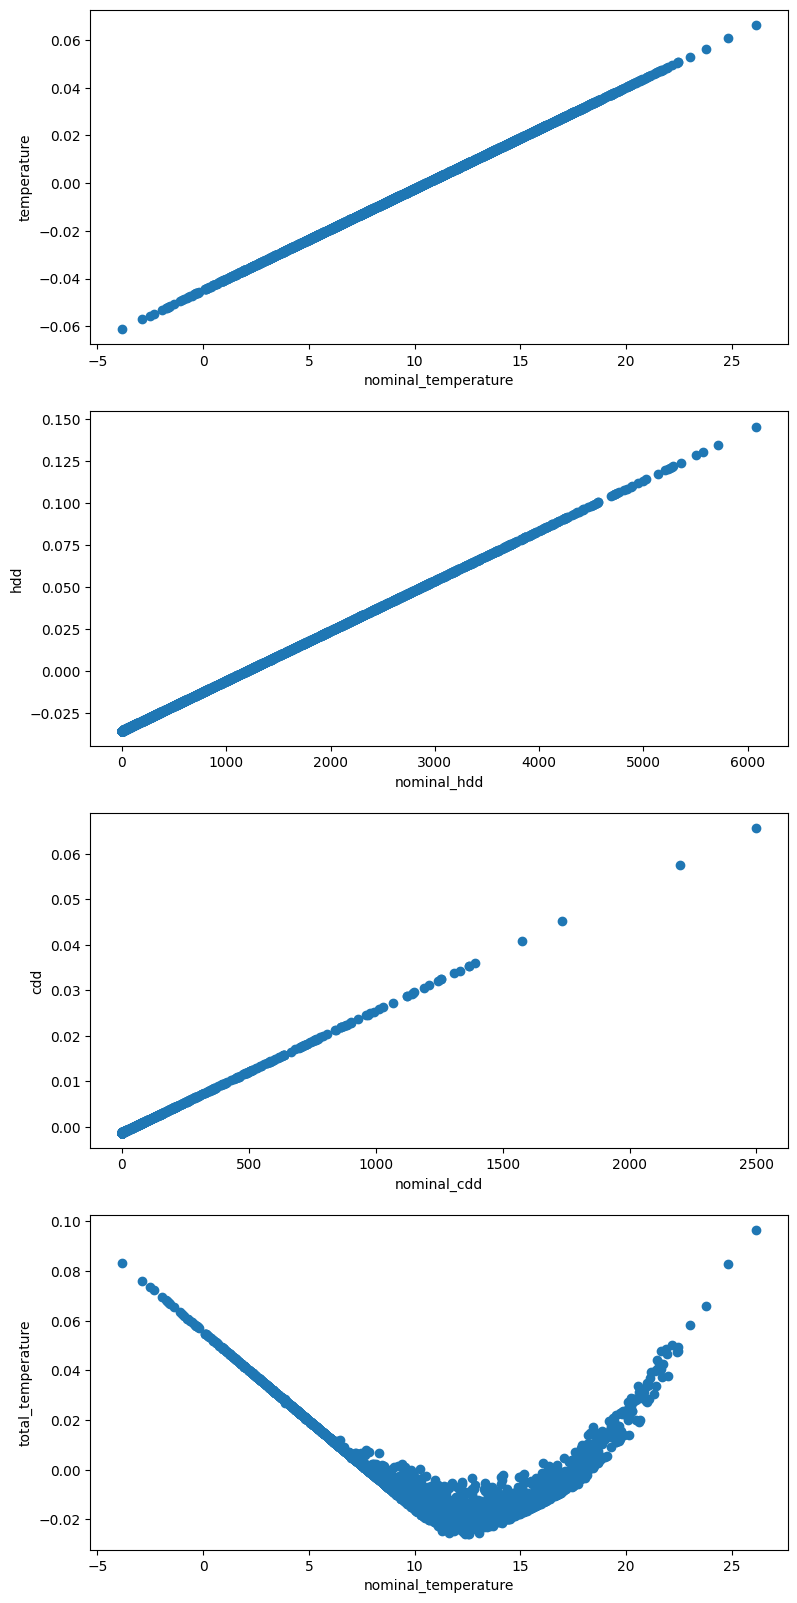

In [165]:
# Plotting Weather Regressors
fig = utils.plot_regressors_linearity(best_model)

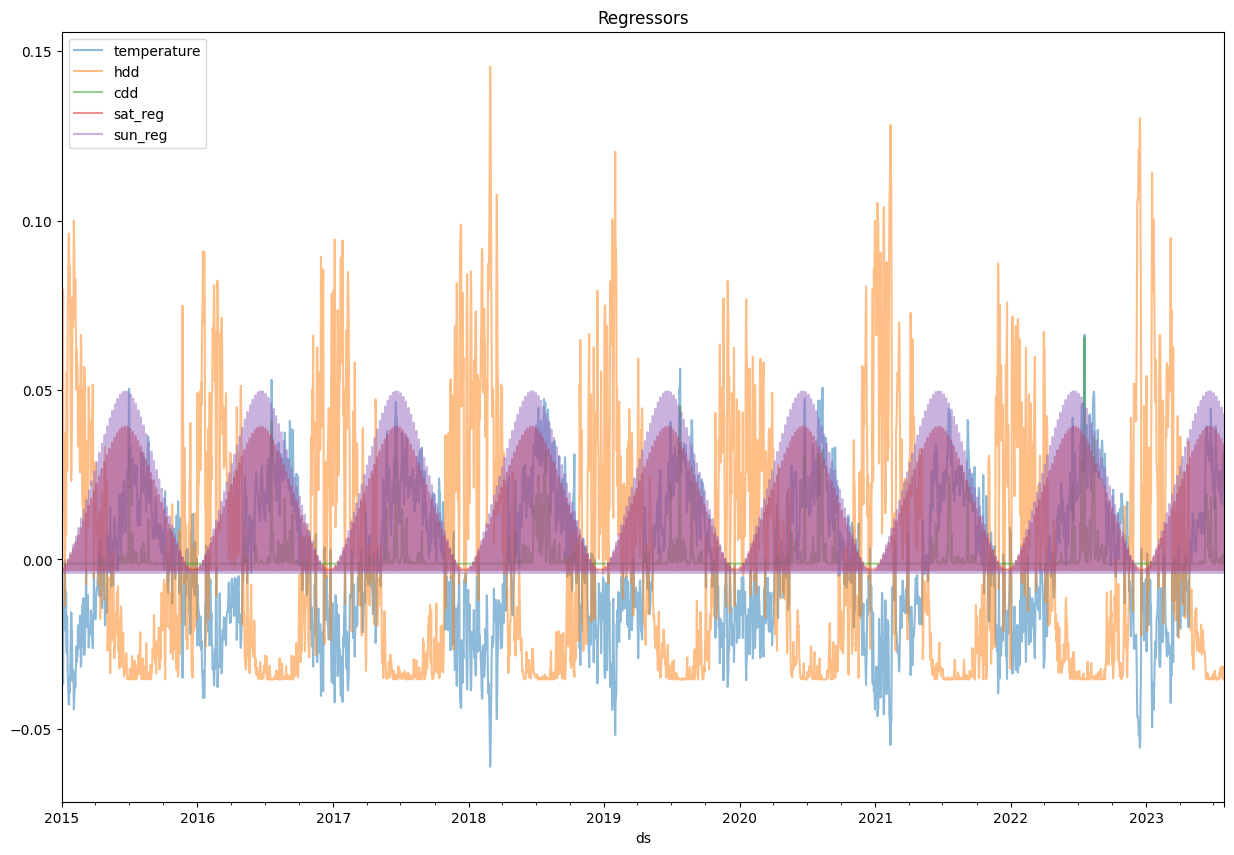

In [173]:
# Plotting Regressors' weights throughout time
fig2 = utils.plot_regressors(best_model)

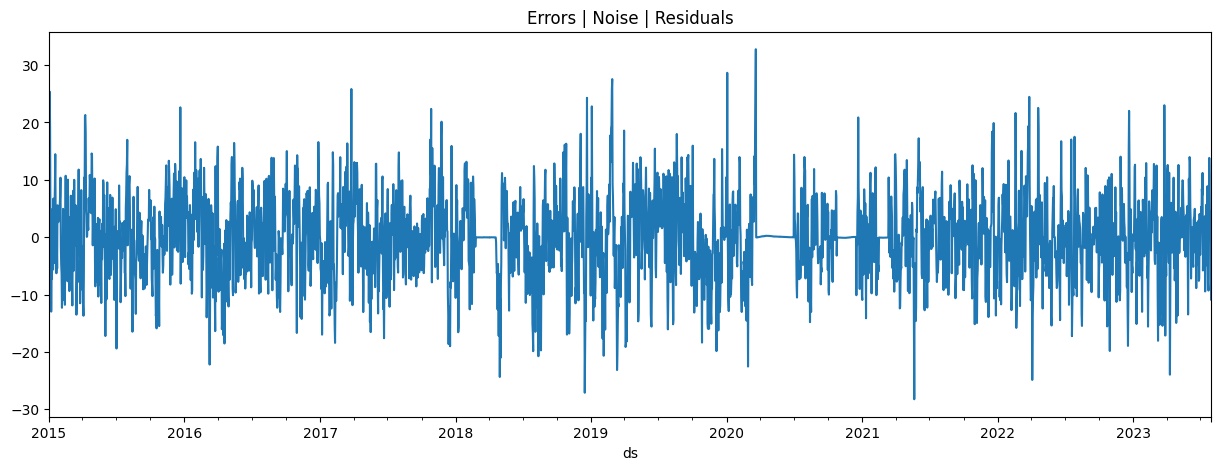

In [174]:
# Plotting Model's Noise / Errors
fig3 = utils.plot_noise_ts(best_model)

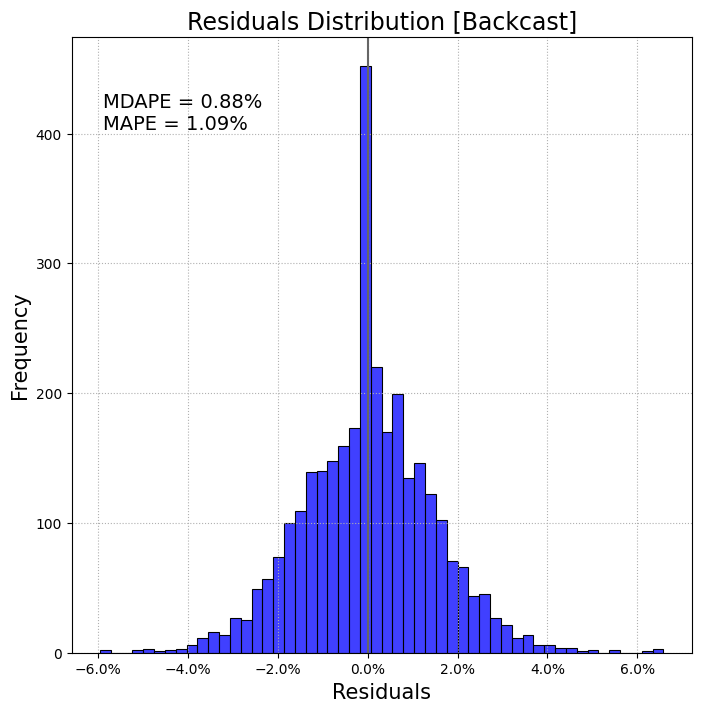

In [175]:
# Histogram of Model's Errors
fig4 = utils.plot_error_hist(best_model)

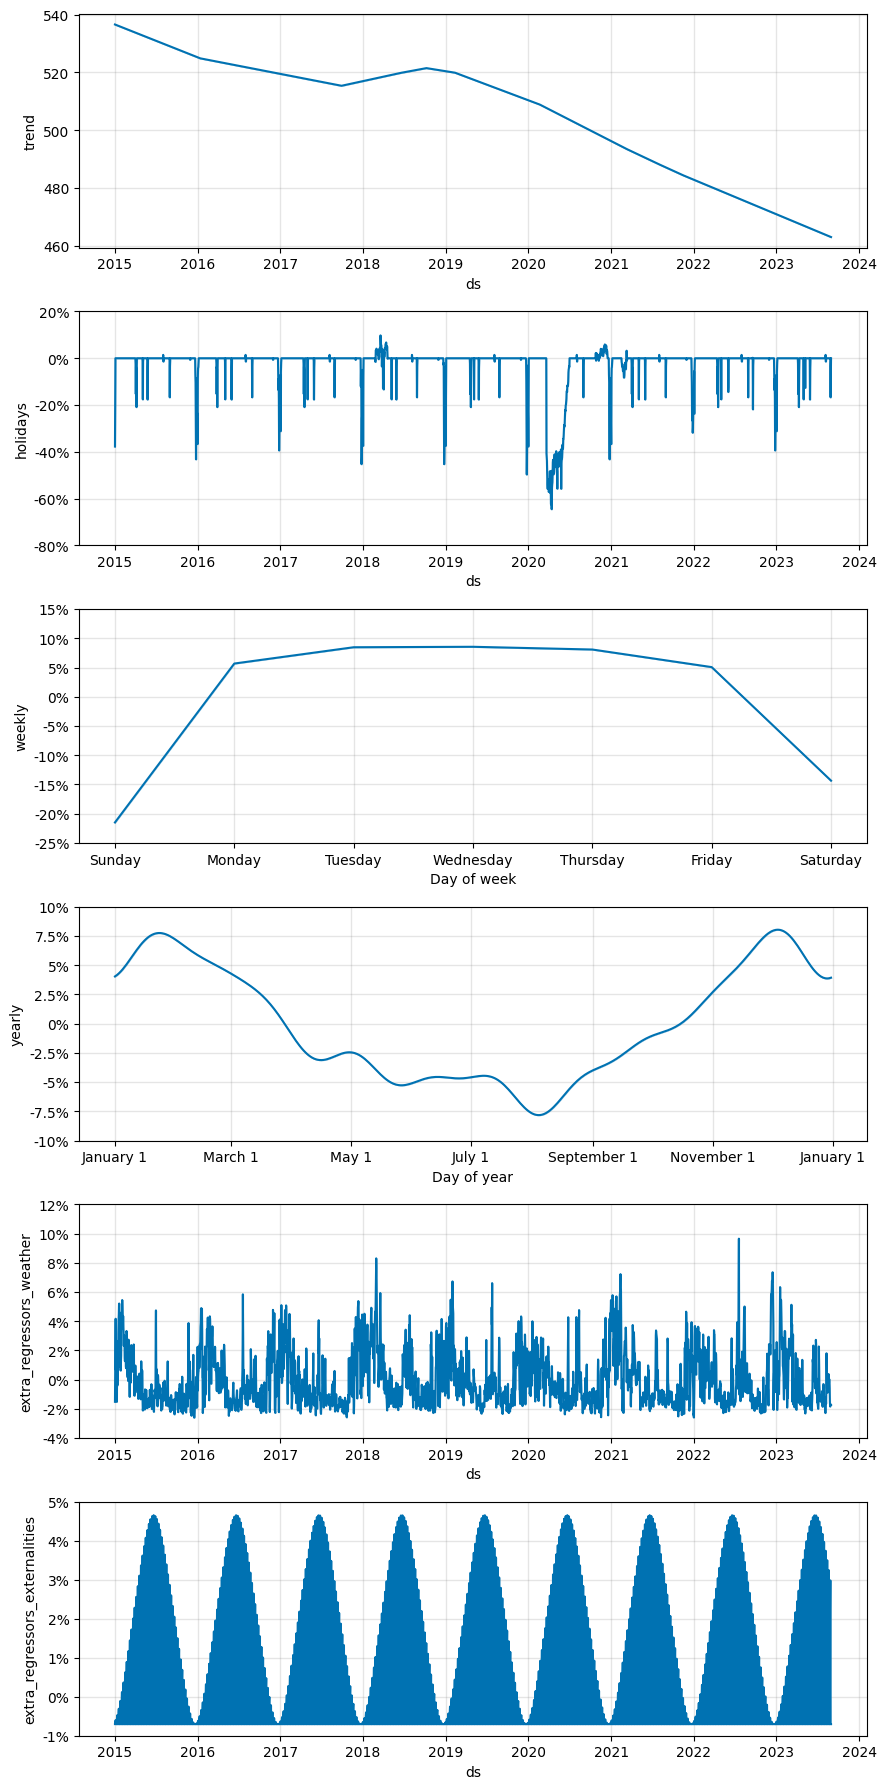

In [176]:
# Plotting components Tidely 
fig5 = utils.plot_base_components(best_model)

In [180]:
best_model.reduced_forecast.to_parquet(os.path.join(outputs_path,f"{category}_{granularity}_reduced_forecast.parquet"))
best_model.full_forecast.to_parquet(os.path.join(outputs_path,f"{category}_{granularity}_full_forecast.parquet"))